# < 9. 폐렴 진단기 성능개선 >

## [루브릭]
1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

## [폐렴 구별법]

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/11_l7pucvb.png)

- X-RAY 사진상, 다양한 양상의 음영(폐 부위에 희미한 그림자) 증가가 관찰된다. 구별 방법은 간단하지만 실제로 영상을 보면 희미한 경우가 많이 있어 저게 실제로 폐렴으로 인한 것인지 아니면 다른 이유 때문인지 파악하기 어렵다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/12_e0QcAmT.png)

- 정상적인 흉부 X-RAY(왼쪽)는 이미지에서 비정상적인 음영 영역이 없는 깨끗한 폐를 보여준다. 세균성 폐렴 (가운데)은 일반적으로 오른쪽 상부 엽 (흰색 화살표)에 있는 나타내는 반면, 바이러스성 폐렴 (오른쪽)은 양쪽 폐에서보다 확산된 "interstitial(조직 사이에 있는)" 패턴으로 나타난다.

## [순서]
1. 실험환경 set-up
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화
8. 회고

---

## Step1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

BATCH_SIZE = 32
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel


---

## Step2. 데이터 준비하기

### 데이터 분리

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


 ▶ 개수 비는 89%, 10.7%, 0.3%이다. val 개수가 너무 적기 때문에 train에서 val에 쓰일 데이터를 더 가져온다. train과 val을 합친후 80:20으로 분할한다

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담는다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눈다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


 ▼ 파일 경로 확인

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


 ▶ 파일경로를 확인해보니 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있다. 또한, 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있다.

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


▶ 정상보다 폐렴 이미지 수가 3배 더 많이 있다. 사용할 CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 더 잘 한다
<br> ▶ 클래스 불균형은 뒤에서 조정

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

▼ Train 데이터셋, validation 데이터셋 개수 확인

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### 라벨 데이터 생성

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

▶ 이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄인다
<br> ▶ process_path 함수에서 decode_img 함수를 이용해서 이미지의 데이터 타입을 float으로 바꾸고 사이즈를 변경한다

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

▼ 확인

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#### tf.data.experimental.cardinality(dataset)
- dataset의 카디널리티를 반환한다. ( 카디널리티 = 원소의 수 )

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

▶ Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해준다. tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜준다. (https://www.tensorflow.org/guide/data?hl=ko) <br>
▶ shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택 <br>
▶ repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해준다 <br>
▶ batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치로 주어진다 <br>
▶ prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에, 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어 리소스의 유휴 상태를 줄일 수 있다

---

## Step3. 데이터 시각화

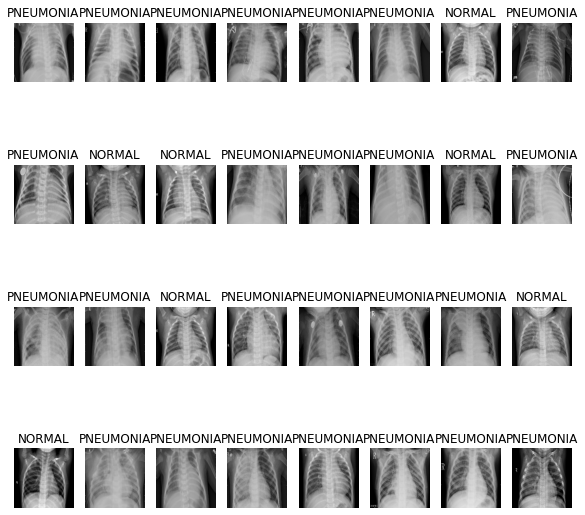

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여준다
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

---

## Step4. CNN 모델링

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

▶ Convolution을 두 번 진행 <br>
▶ Batch Normalization을 통해서 Gradient vanishing, Gradient Exploding을 해결 <br>
▶ 그리고 Max Pooling

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

▶  Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

---

## Step5. 데이터 imbalance 처리
- 데이터를 학습할 때 imbalace한 데이터의 경우 학습 효과가 좋지 않을 수 있다
- 이런 문제들을 해결하는 방법으로 Weigth balancing 이라는 테크닉이 사용
- Weight balancing :  training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


---

## Step6. 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
130/130 [==============================] - 85s 380ms/step - loss: 0.3895 - accuracy: 0.7945 - precision: 0.9509 - recall: 0.7631 - val_loss: 0.5831 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 2/25
130/130 [==============================] - 49s 377ms/step - loss: 0.1928 - accuracy: 0.9252 - precision: 0.9781 - recall: 0.9203 - val_loss: 0.6934 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 3/25
130/130 [==============================] - 49s 378ms/step - loss: 0.1784 - accuracy: 0.9337 - precision: 0.9769 - recall: 0.9327 - val_loss: 0.9590 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 4/25
130/130 [==============================] - 50s 386ms/step - loss: 0.1440 - accuracy: 0.9478 - precision: 0.9848 - recall: 0.9444 - val_loss: 1.1599 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 5/25
130/130 [==============================] - 54s 415ms/step - loss: 0.1362 - accura

---

## Step7. 결과 확인과 시각화

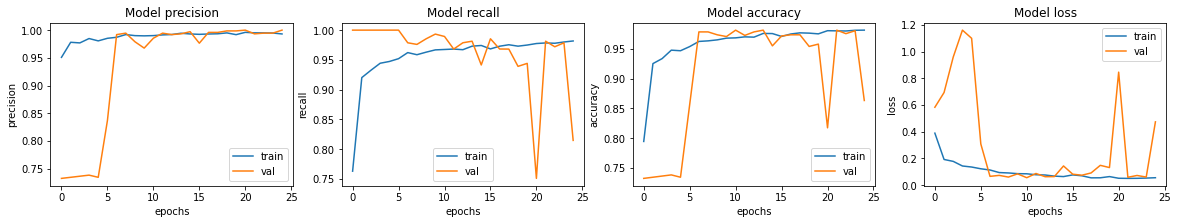

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 228ms/step - loss: 0.4538 - accuracy: 0.8878 - precision: 0.9233 - recall: 0.8949
Loss: 0.4537998139858246,
Accuracy: 0.8878205418586731,
Precision: 0.9232804179191589,
Recall: 0.8948717713356018


---

## 정리

### (1) 정확도 85% 이상
- BATCH SIZE 32로 수정 후 Batch Normalization과 Dropout 두 가지 함께 있는 모델을 사용해서 Accuracy 약 88%에 도달하였다.
- 그래프를 보면 model precision은 train과 val가 거의 일치하는걸 알 수 있다. 이는 정답이라고 예측한 것들 중에 실제로 정답이 많았음을 알려준다. 
- model recall을 보면 중간에 훅 떨어졌다 오르는 부분이 있음을 알 수 있는데 급격한 감소에 대한 원인은 모르겠지만 정확도가 85%가 넘었다해서 좋은 모델이라고 할 수 있을지 모르겠다. 폐렴인 환자를 실제 폐렴이라고 진단하는게 중요하기 때문에 recall 값이 중요한데 recall값이 약 0.89로 낮게 나왔다. 실제 폐렴인 사람에 대해 예측을 잘 못한것 같다.
- model recall, accuracy, loss 모두 에폭 20일때 급격하게 감소하거나 증가하는 경향을 보이다가 안정적인 후 다시 급격하게 감소하거나 증가하는데 원인이 무엇일까 과적합인가 이점은 알 수 없다..! 

### (2) 여러시도

#### 1. 배치사이즈 16
 ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FMadwF%2FbtrsxIkHwWG%2F52xXVDgBw3jO3MAl5hxkU0%2Fimg.png)

▶ 노드에 있는 값으로 실행했을 시에는 Accuracy가 약 83% 정도 나온다 <br>
▶ Precision은 낮지만 Recall을 보면 Accuracy가 88%가 나온 모델보다 훨씬 높다. <br>
▶ 이 모델은 실제 폐렴인 환자를 폐렴이라고 잘 예측한 것 같다 <br>
▶ model loss 그래프를 보면 train과 val이 거의 비슷하다

#### 2. 배치사이즈 16 / 드롭아웃 제거
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcsQL5w%2Fbtrsytg4WsK%2FZsFBTCxV7WKMLidI7g9k3K%2Fimg.png)

▶ 드롭아웃을 모두 제거했더니 Accuracy가 약 80%가 나온 것을 볼 수 있다 <br>
▶ 여기서는  Batch Normalization과 Dropout을 함께 사용하는게 성능이 좋아지는 것 같다 <br>
▶ 이 모델또한 Recall 값이 상당히 높은걸 알 수 있다

#### 3. 배치사이즈 32  / 드롭아웃제거
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F61H6I%2FbtrsrRDgv9W%2FJvVjkLn5RzQEwQ2kUTLA4k%2Fimg.png)

▶ 드롭아웃을 제거하니 같은 배치사이즈인 모델과 비교해서 Accuracy가 많이 떨어진 것을 알 수 있다 <br>
▶ 하지만 이 모델또한 Recall값이 드롭아웃을 사용한 모델과 비교하면 상당히 높다 <br>

#### 4. 배치사이즈 32 /  augmentation 사용
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FzFzwU%2FbtrsxJRqQzQ%2FGD6IsTgPRXNEMKbN5rOjvk%2Fimg.png)

▶ 좌우 반전 정도의 augmentation를 도입해보았다. augmentation을 사용하지 않은 모델에 비해 Accuracy는 낮게 나왔다 <br>
▶ 그렇지만 이 모델또한 Recall값이 약 0.95로 높게 나왔다 <br>
▶ 하지만 의료 영상의 경우 정확하게 구분할 수 있어야 하는게 중요한데 augmentation을 사용시에 노이즈가 더해져서 오히려 방해를 줄 수 있기 때문에 사용하는게 좋지 않다고 생각한다

### (3) 모델에 대해

#### < SeparableConv2D > 
- 그동안 모델을 구성할 때 Conv2D 레이어만 사용해왔는데 SeparableConv2D 레이어를 처음 사용해서 이에 대해 궁금했다.
- Separable Convolution
    - 입력 채널별로 따로따로 공간 방향의 합성곱 수행 후, 1x1 합성곱으로 출력 채널을 합치는 것. 
    - 이로 인해 공간 특성의 학습과 채널 방향 특성의 학습을 분리하는 효과를 얻을 수 있다
    - 채널 수를 조절할 수 있는데 채널의 수가 줄면 파라미터가 줄어드는 것으로, 동시에 계산량이 같이 줄어들어서 더 작고 빠른 모델을 제작할 수 있다
    - 1x1 Convolution의 특징
        - 공간적인 특성을 가지고 있지 않다
        - 연산량이 가장 적게 필요로 하기 때문에, Feature Map 개수를 조절할 때 사용된다
        - https://coding-yoon.tistory.com/116
- 이 특성을 가지고 모델을 더 깊게 구성하면, 기존의 모델보다 더 많은 비선형성 활성화 함수를 사용할 수 있고, 더 구체적인 패턴을 파악해 성능 향상으로 이어진다고 한다
- https://eehoeskrap.tistory.com/431
- https://coding-yoon.tistory.com/122
- https://forbetterdays.tistory.com/70
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/SeparableConv2D

### (4) 느낀점
- 의료분야의 인공지능에 대해서 관심을 가지고 있었기 때문에 이번 프로젝트가 굉장히 재미있고 좀 더 자세히 보려고 노력했던 것 같다. 아무래도 의료분야쪽은 전문지식이 어느정도 필요하다고 생각한다. 모델을 잘 학습시키려면 모델을 잘 학습시키기 위한 데이터가 있어야 하는데 이 데이터에 대해 잘 알아야하기 때문에 이쪽은 전문지식이 있어야 한다고 생각한다. 그래서 augmentation를 도입하는게 조심스러웠다. 오히려 정확도를 떨어지게 만들거라고 생각했는데 여러번의 학습결과를 보면 augmentation을 사용하지 않은게 정확도가 좀 더 높았다. 정말 데이터가 부족한 경우라면 augmentatino을 잘 사용하면 좋은 결과를 만들 수 있을거라 생각한다
- 딥러닝에 대한 기본지식을 점점 알아가게 되니 이해할 수 있는 코드들도 많아졌다. 모델을 점점 이해할 수 있다는게 조금 뿌듯하다! 하면 할수록 데이터를 정제하는 과정이 너무나 중요하다는 것을 느끼고 있으며 그런면에 부족함을 느끼고 있어서 능숙해지기 위해 노력중이다.